In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score

from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras import Model
import tensorflow_addons as tfa


from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook

pd.set_option('display.max_columns', None)

In [2]:
TRAIN_TRANSACTIONS_PATH = '../input/alfabattle2-sandbox/alfabattle2_sand_alfabattle2_train_transactions_contest/train_transactions_contest'
TEST_TRANSACTIONS_PATH = '../input/alfabattle2-sandbox/alfabattle2_sand_alfabattle2_test_transactions_contest/test_transactions_contest'

TRAIN_TARGET_PATH = '../input/alfabattle2-sandbox/alfabattle2_sand_alfabattle2_train_target.csv'

In [3]:
target_frame = pd.read_csv(TRAIN_TARGET_PATH)

In [4]:
def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразует их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset) 
                              if filename.startswith('part')])
    
    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)
    return pd.concat(res).reset_index(drop=True)

In [5]:
from typing import Dict

features = ['currency', 'operation_kind', 'card_type', 'operation_type', 'operation_type_group', 'ecommerce_flag',
            'payment_system', 'income_flag', 'mcc', 'country', 'city', 'mcc_category', 'day_of_week',
            'hour', 'weekofyear', 'amnt', 'days_before', 'hour_diff']

def pad_sequence(array, max_len) -> np.array:
    """
    принимает список списков (array) и делает padding каждого вложенного списка до max_len
    :param array: список списков
    :param max_len: максимальная длина до которой нужно сделать padding
    :return: np.array после padding каждого вложенного списка до одинаковой длины
    """
    add_zeros = max_len - len(array[0])
    return np.array([list(x) + [0] * add_zeros for x in array])


def truncate(x, num_last_transactions=750):
    return x.values.transpose()[:, -num_last_transactions:].tolist()


def transform_transactions_to_sequences(transactions_frame: pd.DataFrame,
                                        num_last_transactions=750) -> pd.DataFrame:
    """
    принимает frame с транзакциями клиентов, сортирует транзакции по клиентам
    (внутри клиента сортирует транзакции по возрастанию), берет num_last_transactions танзакций,
    возвращает новый pd.DataFrame с двумя колонками: app_id и sequences.
    каждое значение в колонке sequences - это список списков.
    каждый список - значение одного конкретного признака во всех клиентских транзакциях.
    Всего признаков len(features), поэтому будет len(features) списков.
    Данная функция крайне полезна для подготовки датасета для работы с нейронными сетями.
    :param transactions_frame: фрейм с транзакциями клиентов
    :param num_last_transactions: количество транзакций клиента, которые будут рассмотрены
    :return: pd.DataFrame из двух колонок (app_id, sequences)
    """
    return transactions_frame \
        .sort_values(['app_id', 'transaction_number']) \
        .groupby(['app_id'])[features] \
        .apply(lambda x: truncate(x, num_last_transactions=num_last_transactions)) \
        .reset_index().rename(columns={0: 'sequences'})

In [6]:
def create_padded_buckets(frame_of_sequences: pd.DataFrame, bucket_info: Dict[int, int],
                          save_to_file_path=None, has_target=True):
    """
    Функция реализует sequence_bucketing технику для обучения нейронных сетей.
    Принимает на вход frame_of_sequences (результат работы функции transform_transactions_to_sequences),
    словарь bucket_info, где для последовательности каждой длины указано, до какой максимальной длины нужно делать
    padding, далее группирует транзакции по бакетам (на основе длины), делает padding транзакций и сохраняет результат
    в pickle файл, если нужно
    :param frame_of_sequences: pd.DataFrame c транзакциями (результат применения transform_transactions_to_sequences)
    :param bucket_info: словарь, где для последовательности каждой длины указано, до какой максимальной длины нужно делать
    padding
    :param save_to_file_path: опциональный путь до файла, куда нужно сохранить результат
    :param has_target: флаг, есть ли в frame_of_sequences целевая переменная или нет. Если есть, то
    будет записано в результат
    :return: возвращает словарь с следюущими ключами (padded_sequences, targets, app_id, products)
    """
    frame_of_sequences['bucket_idx'] = frame_of_sequences.sequence_length.map(bucket_info)
    padded_seq = []
    targets = []
    app_ids = []
    products = []

    for size, bucket in frame_of_sequences.groupby('bucket_idx'):
        padded_sequences = bucket.sequences.apply(lambda x: pad_sequence(x, size)).values
        padded_sequences = np.array([np.array(x) for x in padded_sequences])
        padded_seq.append(padded_sequences)

        if has_target:
            targets.append(bucket.flag.values)

        app_ids.append(bucket.app_id.values)
        products.append(bucket['product'].values)

    frame_of_sequences.drop(columns=['bucket_idx'], inplace=True)

    dict_result = {
        'padded_sequences': np.array(padded_seq, dtype=object),
        'targets': np.array(targets, dtype=object) if targets else [],
        'app_id': np.array(app_ids, dtype=object),
        'products': np.array(products, dtype=object),
    }

    if save_to_file_path:
        with open(save_to_file_path, 'wb') as f:
            pickle.dump(dict_result, f)
    return dict_result

In [7]:
import pickle

with open('../input/alfabattle2-sandbox/constants_for_rnn/constants_for_rnn/buckets_info.pkl', 'rb') as f:
    mapping_seq_len_to_padded_len = pickle.load(f)
    
with open('../input/alfabattle2-sandbox/constants_for_rnn/constants_for_rnn/dense_features_buckets.pkl', 'rb') as f:
    dense_features_buckets = pickle.load(f)

In [8]:
def create_buckets_from_transactions(path_to_dataset, save_to_path, frame_with_ids = None, 
                                     num_parts_to_preprocess_at_once: int = 1, 
                                     num_parts_total=50, has_target=False):
    block = 0
    for step in tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once), 
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once, 
                                                             verbose=True)
        for dense_col in ['amnt', 'days_before', 'hour_diff']:
            transactions_frame[dense_col] = np.digitize(transactions_frame[dense_col], bins=dense_features_buckets[dense_col])
            
        seq = transform_transactions_to_sequences(transactions_frame)
        seq['sequence_length'] = seq.sequences.apply(lambda x: len(x[1]))
        
        if frame_with_ids is not None:
            seq = seq.merge(frame_with_ids, on='app_id')

        block_as_str = str(block)
        if len(block_as_str) == 1:
            block_as_str = '00' + block_as_str
        else:
            block_as_str = '0' + block_as_str
            how
        processed_fragment =  create_padded_buckets(seq, mapping_seq_len_to_padded_len, has_target=has_target, 
                                                    save_to_file_path=os.path.join(save_to_path, 
                                                                                   f'processed_chunk_{block_as_str}.pkl'))
        block += 1

In [9]:
path_to_dataset = '../input/train-val-buckets/val_buckets'
dir_with_datasets = os.listdir(path_to_dataset)
dataset_val = sorted([os.path.join(path_to_dataset, x) for x in dir_with_datasets])
dataset_val

['../input/train-val-buckets/val_buckets/processed_chunk_000.pkl',
 '../input/train-val-buckets/val_buckets/processed_chunk_001.pkl',
 '../input/train-val-buckets/val_buckets/processed_chunk_002.pkl',
 '../input/train-val-buckets/val_buckets/processed_chunk_003.pkl',
 '../input/train-val-buckets/val_buckets/processed_chunk_004.pkl',
 '../input/train-val-buckets/val_buckets/processed_chunk_005.pkl',
 '../input/train-val-buckets/val_buckets/processed_chunk_006.pkl',
 '../input/train-val-buckets/val_buckets/processed_chunk_007.pkl',
 '../input/train-val-buckets/val_buckets/processed_chunk_008.pkl',
 '../input/train-val-buckets/val_buckets/processed_chunk_009.pkl',
 '../input/train-val-buckets/val_buckets/processed_chunk_010.pkl',
 '../input/train-val-buckets/val_buckets/processed_chunk_011.pkl',
 '../input/train-val-buckets/val_buckets/processed_chunk_012.pkl',
 '../input/train-val-buckets/val_buckets/processed_chunk_013.pkl',
 '../input/train-val-buckets/val_buckets/processed_chunk_014.p

In [10]:
path_to_dataset = '../input/train-val-buckets/train_buckets'
dir_with_datasets = os.listdir(path_to_dataset)
dataset_train = sorted([os.path.join(path_to_dataset, x) for x in dir_with_datasets])
dataset_train

['../input/train-val-buckets/train_buckets/processed_chunk_000.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_001.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_002.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_003.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_004.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_005.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_006.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_007.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_008.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_009.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_010.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_011.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_012.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_013.pkl',
 '../input/train-val-buckets/train

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [12]:
transaction_features = ['currency', 'operation_kind', 'card_type', 'operation_type',
                        'operation_type_group', 'ecommerce_flag', 'payment_system',
                        'income_flag', 'mcc', 'country', 'city', 'mcc_category',
                        'day_of_week', 'hour', 'weekofyear', 'amnt', 'days_before', 'hour_diff']

def batches_generator(list_of_paths, batch_size=32, shuffle=False, is_infinite=False,
                      verbose=False, device=None, output_format='tf', is_train=True):
    """
    функция для создания батчей на вход для нейронной сети для моделей на keras и pytorch.
    так же может использоваться как функция на стадии инференса
    :param list_of_paths: путь до директории с предобработанными последовательностями
    :param batch_size: размер батча
    :param shuffle: флаг, если True, то перемешивает list_of_paths и так же
    перемешивает последовательности внутри файла
    :param is_infinite: флаг, если True,  то создает бесконечный генератор батчей
    :param verbose: флаг, если True, то печатает текущий обрабатываемый файл
    :param device: device на который положить данные, если работа на торче
    :param output_format: допустимые варианты ['tf', 'torch']. Если 'torch', то возвращает словарь,
    где ключи - батчи из признаков, таргетов и app_id. Если 'tf', то возвращает картеж: лист input-ов
    для модели, и список таргетов.
    :param is_train: флаг, Если True, то для кераса вернет (X, y), где X - input-ы в модель, а y - таргеты, 
    если False, то в y будут app_id; для torch вернет словарь с ключами на device.
    :return: бачт из последовательностей и таргетов (или app_id)
    """
    while True:
        if shuffle:
            np.random.shuffle(list_of_paths)

        for path in list_of_paths:
            if verbose:
                print(f'reading {path}')

            with open(path, 'rb') as f:
                '''
                26.pkl is truncated 
                '''
                if path == '../input/train-val-buckets/train_buckets/processed_chunk_026.pkl':
                    continue
                data = pickle.load(f)
            padded_sequences, targets, products = data['padded_sequences'], data['targets'], data[
                'products']
            app_ids = data['app_id']
            indices = np.arange(len(products))

            if shuffle:
                np.random.shuffle(indices)
                padded_sequences = padded_sequences[indices]
                targets = targets[indices]
                products = products[indices]
                app_ids = app_ids[indices]

            for idx in range(len(products)):
                bucket, product = padded_sequences[idx], products[idx]
                app_id = app_ids[idx]
                
                if is_train:
                    target = targets[idx]
                
                for jdx in range(0, len(bucket), batch_size):
                    batch_sequences = bucket[jdx: jdx + batch_size]
                    if is_train:
                        batch_targets = target[jdx: jdx + batch_size]
                    
                    batch_products = product[jdx: jdx + batch_size]
                    batch_app_ids = app_id[jdx: jdx + batch_size]
                    
                    if output_format == 'tf':
                        batch_sequences = [batch_sequences[:, i] for i in
                                           range(len(transaction_features))]
                        
                        # append product as input to tf model
                        batch_sequences.append(batch_products)
                        if is_train:
                            yield batch_sequences, batch_targets
                        else:
                             yield batch_sequences, batch_app_ids
                    else:
                        batch_sequences = [torch.LongTensor(batch_sequences[:, i]).to(device)
                                           for i in range(len(transaction_features))]
                        if is_train:
                            yield dict(transactions_features=batch_sequences,
                                       product=torch.LongTensor(batch_products).to(device),
                                       label=torch.LongTensor(batch_targets).to(device),
                                       app_id=batch_app_ids)
                        else:
                            yield dict(transactions_features=batch_sequences,
                                       product=torch.LongTensor(batch_products).to(device),
                                       app_id=batch_app_ids)
        if not is_infinite:
            break

In [13]:
class EarlyStopping:
    """Early stops the training if validation metric doesn't improve after a given patience."""

    def __init__(self, patience=7, mode='min', verbose=False, delta=0, save_path='checkpoint.hdf5', metric_name=None, save_format='tf'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            mode (str): One of ['min', 'max'], whether to maximize or minimaze the metric.
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            save_path (str): Path to saved model
        """
        if mode not in ['min', 'max']:
            raise ValueError(f'Unrecognized mode: {mode}!')

        self.patience = patience
        self.mode = mode
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_prev_score = np.Inf if mode == 'min' else -np.Inf
        self.delta = delta
        self.save_path = save_path
        self.metric_name = 'metric' if not metric_name else metric_name
        if save_format not in ['torch', 'tf']:
            raise ValueError('Expected to save in one of the following formats: ["torch", "tf"]')
        self.save_format = save_format
        
    def __call__(self, metric_value, model):

        score = -metric_value if self.mode == 'min' else metric_value

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(metric_value, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                f'No imporvement in Validation {self.metric_name}. Current: {score:.6f}. Current best: {self.best_score:.6f}')
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(metric_value, model)
            self.counter = 0

    def save_checkpoint(self, metric_value, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            print(
                f'Validation {self.metric_name} improved ({self.best_prev_score:.6f} --> {metric_value:.6f}).  Saving model ...')
        if self.save_format == 'tf':
            model.save_weights(self.save_path)
        else:
            torch.save(model.state_dict(), self.save_path)
            
        self.best_prev_score = metric_value

## TF-training

In [14]:
def train_epoch(model, dataset_train, batch_size=64, shuffle=True, cur_epoch=0,
                steps_per_epoch=5000, callbacks=None):
    """
    функция обучения модели одну эпоху
    :param model: tf.keras.Model
    :param dataset_train: путь до директории с последовательностями
    :param batch_size: размер батча
    :param shuffle: флаг, если True, то перемешивает данные
    :param cur_epoch:
    :param steps_per_epoch:
    :param callbacks: cписок из tf.keras.callbacks или None
    :return: None
    """
    train_generator = batches_generator(dataset_train, batch_size=batch_size, shuffle=shuffle,
                                        output_format='tf', is_train=True)
    model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=cur_epoch + 1,
              initial_epoch=cur_epoch, callbacks=callbacks)


In [15]:
def eval_model(model, dataset_val, batch_size=32) -> float:
    """
    функция для оценки качества модели на отложенной выборке, возвращает roc-auc на валидационной
    выборке
    :param model: tf.keras.Model
    :param dataset_val: путь до директории с последовательностями
    :param batch_size: размер батча
    :return: val roc-auc score
    """
    val_generator = batches_generator(dataset_val, batch_size=batch_size, shuffle=False,
                                      output_format='tf', is_train=True)
    preds = model.predict(val_generator).flatten()
    val_generator = batches_generator(dataset_val, batch_size=batch_size, shuffle=False,
                                      output_format='tf', is_train=True)
    targets = []
    for _, y in val_generator:
        targets.extend(y)

    return roc_auc_score(targets, preds)

In [16]:
def inference(model, dataset_test, batch_size=32) -> pd.DataFrame:
    """
    функция, которая делает предикты на новых данных, возвращает pd.DataFrame из двух колонок:
    (app_id, score)
    :param model: tf.keras.Model
    :param dataset_test: путь до директории с последовательностями
    :param batch_size: размер батча
    :return: pd.DataFrame из двух колонок: (app_id, score)
    """
    app_ids = []
    test_generator = batches_generator(dataset_test, batch_size=batch_size, shuffle=False,
                                       is_train=False, output_format='tf')
    
    preds = model.predict(test_generator).flatten()
    
    app_ids = []
    test_generator = batches_generator(dataset_test, batch_size=batch_size, shuffle=False, 
                                       is_train=False, output_format='tf')
    for _, y in test_generator:
        app_ids.extend(y)
        
    return pd.DataFrame({
        'app_id': app_ids,
        'score': preds
    })

In [17]:
with open('../input/alfabattle2-sandbox/constants_for_rnn/constants_for_rnn/embedding_projections.pkl', 'rb') as f:
    embedding_projections = pickle.load(f)

In [18]:
def transactions_rnn(transactions_cat_features, embedding_projections, product_col_name='product', 
                          rnn_units=128, classifier_units=32, optimizer=None):
    if not optimizer:
        optimizer = keras.optimizers.Adam(learning_rate=1e-3)
        
    inputs = []
    cat_embeds = []
    
    for feature_name in transactions_cat_features:
        inp = L.Input(shape=(None, ), dtype='uint32', name=f'input_{feature_name}')
        inputs.append(inp)
        source_size, projection = embedding_projections[feature_name]
        emb = L.Embedding(source_size+1, projection, trainable=True, mask_zero=False, name=f'embedding_{feature_name}')(inp)
        cat_embeds.append(emb)
    
    # product feature
    inp = L.Input(shape=(1, ), dtype='uint32', name=f'input_product')
    inputs.append(inp)
    source_size, projection = embedding_projections['product']
    product_emb = L.Embedding(source_size+1, projection, trainable=True, mask_zero=False, name=f'embedding_product')(inp)
    product_emb_reshape = L.Reshape((projection, ))(product_emb)
    
    concated_cat_embeds = L.concatenate(cat_embeds)
    
    last_state = L.GRU(units=rnn_units)(concated_cat_embeds)
    
    combined_inp = L.concatenate([last_state, product_emb_reshape])
    
    dense_intermediate = L.Dense(classifier_units, activation='relu', )(combined_inp)
    proba = L.Dense(1, activation='sigmoid')(dense_intermediate)
    
    model = Model(inputs=inputs, outputs=proba)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model


In [19]:
def bigru_pooling_model(transactions_cat_features, embedding_projections, product_col_name='product', 
                          rnn_units=128, classifier_units=32, optimizer=None):
    if not optimizer:
        optimizer = keras.optimizers.Adam(learning_rate=1e-3)
        
    inputs = []
    cat_embeds = []
    
    for feature_name in transactions_cat_features:
        inp = L.Input(shape=(None, ), dtype='uint32', name=f'input_{feature_name}')
        inputs.append(inp)
        source_size, projection = embedding_projections[feature_name]
        emb = L.Embedding(source_size+1, projection, trainable=True, mask_zero=False, name=f'embedding_{feature_name}')(inp)
        emb_dropout = L.Dropout(.3)(emb)
        cat_embeds.append(emb_dropout)
    
    # product feature
    inp = L.Input(shape=(1, ), dtype='uint32', name=f'input_product')
    inputs.append(inp)
    source_size, projection = embedding_projections['product']
    product_emb = L.Embedding(source_size+1, projection, trainable=True, mask_zero=False, name=f'embedding_product')(inp)
    product_emb_reshape = L.Reshape((projection, ))(product_emb)
    
    concated_cat_embeds = L.concatenate(cat_embeds)
    dropout_embeds = L.Dropout(.3)(concated_cat_embeds)
    
    sequences = L.Bidirectional(L.LSTM(units=rnn_units, return_sequences=True))(dropout_embeds)
    dropout_sequences = L.Dropout(.3)(sequences)
    
    pooled_avg_sequences = L.GlobalAveragePooling1D()(sequences)
    pooled_max_sequences = L.GlobalMaxPooling1D()(sequences)
    
    concated = L.concatenate([pooled_avg_sequences, pooled_max_sequences, product_emb_reshape])
    
    dense_intermediate = L.Dense(classifier_units, activation='relu', 
                                 kernel_regularizer=keras.regularizers.L1L2(1e-7, 1e-5))(concated)
    
    proba = L.Dense(1, activation='sigmoid')(dense_intermediate)
    
    model = Model(inputs=inputs, outputs=proba)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

## training

In [20]:
! mkdir ./rnn_baseline

! mkdir ./rnn_baseline/checkpoints

! rm -r ./rnn_baseline/checkpoints/pytorch_baseline
! mkdir ./rnn_baseline/checkpoints/pytorch_baseline

rm: cannot remove './rnn_baseline/checkpoints/pytorch_baseline': No such file or directory


In [21]:
path_to_checkpoints = './rnn_baseline/checkpoints/pytorch_baseline/'
es = EarlyStopping(patience=4, mode='max', verbose=True, save_path=os.path.join(path_to_checkpoints, 'best_checkpoint.pt'), 
                   metric_name='ROC-AUC', save_format='tf')

In [22]:
num_epochs = 10
train_batch_size = 128
val_batch_szie = 128

## Exponential decay

2022-08-03 10:20:55.570815: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 10:20:55.572075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 10:20:55.572784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 10:20:55.575158: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

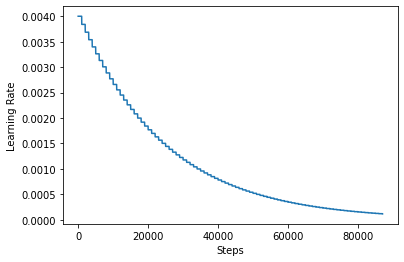

In [23]:
steps_per_epoch = 8707
  
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    4e-3,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

step = np.arange(0, num_epochs * steps_per_epoch)
lr = lr_scheduler(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

## CyclicalLearningRate

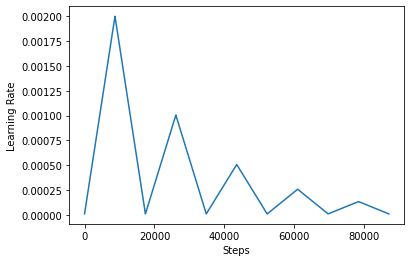

In [24]:
MAX_LR = 2e-3

clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-5,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=1 * steps_per_epoch
)

step = np.arange(0, num_epochs * steps_per_epoch)
lr = clr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [25]:
 lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    1e-3,
    decay_steps=1000,
    decay_rate=0.98,
    staircase=True)

model = bigru_pooling_model(transaction_features, embedding_projections, optimizer=keras.optimizers.Adam(learning_rate=clr))

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_currency (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
input_operation_kind (InputLaye [(None, None)]       0                                            
__________________________________________________________________________________________________
input_card_type (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
input_operation_type (InputLaye [(None, None)]       0                                            
______________________________________________________________________________________________

In [27]:
dataset_train

['../input/train-val-buckets/train_buckets/processed_chunk_000.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_001.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_002.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_003.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_004.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_005.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_006.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_007.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_008.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_009.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_010.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_011.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_012.pkl',
 '../input/train-val-buckets/train_buckets/processed_chunk_013.pkl',
 '../input/train-val-buckets/train

In [28]:
for epoch in range(num_epochs):
    print(f'Starting epoch {epoch+1}')
    
    train_epoch(model, dataset_train, batch_size=train_batch_size, shuffle=True, cur_epoch=epoch, 
                steps_per_epoch=7270)
    
    val_roc_auc = eval_model(model, dataset_val, batch_size=val_batch_szie)
    model.save_weights(os.path.join(path_to_checkpoints, f'epoch_{epoch+1}_val_{val_roc_auc:.3f}.hdf5'))
    
    es(val_roc_auc, model)
    
    if es.early_stop:
        print('Early stopping reached. Stop training...')
        break
        
    train_roc_auc = eval_model(model, dataset_train, batch_size=val_batch_szie)
    print(f'Epoch {epoch+1} completed. Train roc-auc: {train_roc_auc}, Val roc-auc: {val_roc_auc}')

Starting epoch 1


2022-08-03 10:21:06.723109: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-03 10:21:12.507134: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


7270/7270 [==============================] - 408s 55ms/step - loss: 0.1272
Validation ROC-AUC improved (-inf --> 0.757873).  Saving model ...
Epoch 1 completed. Train roc-auc: 0.7569247559569505, Val roc-auc: 0.7578726680695502
Starting epoch 2
Epoch 2/2
7270/7270 [==============================] - 402s 55ms/step - loss: 0.1070
Validation ROC-AUC improved (0.757873 --> 0.761996).  Saving model ...
Epoch 2 completed. Train roc-auc: 0.7669204454313875, Val roc-auc: 0.7619959959937298
Starting epoch 3
Epoch 3/3
7270/7270 [==============================] - 402s 55ms/step - loss: 0.1043
Validation ROC-AUC improved (0.761996 --> 0.778584).  Saving model ...
Epoch 3 completed. Train roc-auc: 0.7890634667967137, Val roc-auc: 0.7785837710046327
Starting epoch 4
Epoch 4/4
7270/7270 [==============================] - 409s 56ms/step - loss: 0.1022
No imporvement in Validation ROC-AUC. Current: 0.776711. Current best: 0.778584
EarlyStopping counter: 1 out of 4
Epoch 4 completed. Train roc-auc: 0.79